# Advanced Modeling Features

## TRISO Particles

OpenMC includes a few convenience functions for generations TRISO particle locations and placing them in a lattice. To be clear, this capability is not a stochastic geometry capability like included in MCNP. It's also important to note that OpenMC does not use delta tracking, which would normally speed up calculations in geometries with tons of surfaces and cells. However, the computational burden can be eased by placing TRISO particles in a lattice.

In [1]:
%matplotlib inline
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import openmc
import openmc.model

import sys
sys.path.append('../..')
from inputs import *

Let's first start by creating materials that will be used in our TRISO particles and the background material.

In [2]:
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.5)
fuel.add_nuclide('U235', 4.6716e-02)
fuel.add_nuclide('U238', 2.8697e-01)
fuel.add_nuclide('O16',  5.0000e-01)
fuel.add_element('C', 1.6667e-01)

buff = openmc.Material(name='Buffer')
buff.set_density('g/cm3', 1.0)
buff.add_element('C', 1.0)
buff.add_s_alpha_beta('c_Graphite')

PyC1 = openmc.Material(name='PyC1')
PyC1.set_density('g/cm3', 1.9)
PyC1.add_element('C', 1.0)
PyC1.add_s_alpha_beta('c_Graphite')

PyC2 = openmc.Material(name='PyC2')
PyC2.set_density('g/cm3', 1.87)
PyC2.add_element('C', 1.0)
PyC2.add_s_alpha_beta('c_Graphite')

SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)
graphite.add_s_alpha_beta('c_Graphite')

To actually create individual TRISO particles, we first need to create a universe that will be used within each particle. The reason we use the same universe for each TRISO particle is to reduce the total number of cells/surfaces needed which can improve performance by a factor of two over using unique cells/surfaces in each.

In [3]:
# Create TRISO universe
spheres = [openmc.Sphere(R=r*1e-4)
           for r in [215., 315., 350., 385.]]
cells = [openmc.Cell(fill=fuel, region=-spheres[0]),
         openmc.Cell(fill=buff, region=+spheres[0] & -spheres[1]),
         openmc.Cell(fill=PyC1, region=+spheres[1] & -spheres[2]),
         openmc.Cell(fill=SiC, region=+spheres[2] & -spheres[3]),
         openmc.Cell(fill=PyC2, region=+spheres[3])]
triso_univ = openmc.Universe(cells=cells)

Now that we have a universe that can be used for each TRISO particle, we need to randomly select locations. In this example, we will select locations at random within in a 1 cm x 1 cm x 1 cm box centered at the origin with a packing fraction of 30%. Note that `pack_trisos` can handle up to the theoretical maximum of 60% (it will just be slow).

In [4]:
outer_radius = 425.*1e-4

trisos = openmc.model.pack_trisos(
    radius=outer_radius,
    fill=triso_univ,
    domain_shape='cube',
    domain_length=1,
    packing_fraction=0.3
)

Note that each TRISO object **is** a Cell, in fact; we can look at the properties of the TRISO just as we would a cell:

In [5]:
print(trisos[0])

Cell
	ID             =	10005
	Name           =	
	Fill           =	10000
	Region         =	-10004
	Rotation       =	None
	Translation    =	[-0.33455672  0.31790187  0.24135378]



Let's confirm that all our TRISO particles are within the box.

In [6]:
centers = np.vstack([t.center for t in trisos])
print(centers.min(axis=0))
print(centers.max(axis=0))

[-0.45718713 -0.45730405 -0.45725048]
[ 0.45705454  0.45743843  0.45741142]


We can also look at what the actual packing fraction turned out to be:

In [7]:
len(trisos)*4/3*pi*outer_radius**3

0.2996893513959326

Now that we have our TRISO particles created, we need to place them in a lattice to provide optimal tracking performance in OpenMC. We'll start by creating a box that the lattice will be placed within.

In [8]:
min_x = openmc.XPlane(x0=-0.5, boundary_type='reflective')
max_x = openmc.XPlane(x0=0.5, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.5, boundary_type='reflective')
max_y = openmc.YPlane(y0=0.5, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.5, boundary_type='reflective')
max_z = openmc.ZPlane(z0=0.5, boundary_type='reflective')
box = openmc.Cell(region=+min_x & -max_x & +min_y & -max_y & +min_z & -max_z)

Our last step is to actually create a lattice containing TRISO particles which can be done with `model.create_triso_lattice()` function. This function requires that we give it a list of TRISO particles, the lower-left coordinates of the lattice, the pitch of each lattice cell, the overall shape of the lattice (number of cells in each direction), and a background material.

In [9]:
lower_left, upper_right = box.region.bounding_box
shape = (3, 3, 3)
pitch = (upper_right - lower_left)/shape
lattice = openmc.model.create_triso_lattice(
    trisos, lower_left, pitch, shape, graphite)

Now we can set the fill of our box cell to be the lattice:

In [10]:
box.fill = lattice

Finally, let's take a look at our geometry by putting the box in a universe and plotting it. We're going to use the Fortran-side plotter since it's much faster.

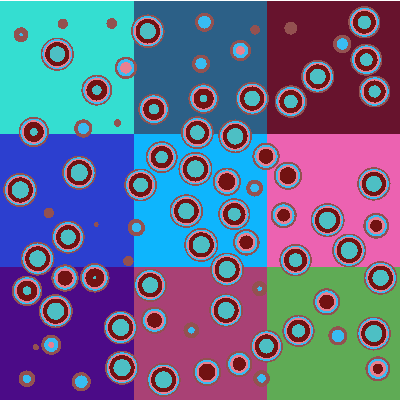

In [11]:
univ = openmc.Universe(cells=[box])

geom = openmc.Geometry(univ)
geom.export_to_xml()

mats = list(geom.get_all_materials().values())
openmc.Materials(mats).export_to_xml()

settings = openmc.Settings()
settings.run_mode = 'plot'
settings.export_to_xml()

p = openmc.Plot.from_geometry(geom)
openmc.plot_inline(p)

If we plot the universe by material rather than by cell, we can see that the entire background is just graphite.

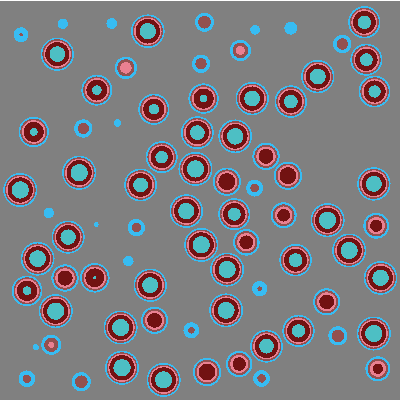

In [12]:
p.color_by = 'material'
p.colors = {graphite: 'gray'}
openmc.plot_inline(p)

## Tally Triggers

Now that we have a cool TRISO model, our boss has asked us what the fission rate in fuel is and he wants to know it such within a relative error (std dev/mean) of 0.1%. Thankfully, OpenMC has a feature called "tally triggers" that allow us to run a simulation until a criterion like this is met, so we don't have to guess how many batches to run.

First, let's create a tally for the fission reaction rate in fuel.

In [13]:
fission_tally = openmc.Tally(1)
fission_tally.filters.append(openmc.MaterialFilter(fuel.id))
fission_tally.scores.append('fission')

Now we need to create trigger and assign it to the tally.

In [14]:
trigger = openmc.Trigger('rel_err', 0.001)
fission_tally.triggers = [trigger]

tallies = openmc.Tallies([fission_tally])
tallies.export_to_xml()

Finally, we need to tell OpenMC to turn on triggers in the first place. Before that, we'll adjust our `Settings` object to run an eigenvalue simulation starting with a point source at the origin.

In [15]:
settings.run_mode = 'eigenvalue'
settings.source = openmc.Source(space=openmc.stats.Point())
settings.batches = 20
settings.inactive = 10
settings.particles = 100

settings.trigger_active = True
settings.trigger_max_batches = 1000
settings.export_to_xml()

In [16]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

KeyboardInterrupt: 

## External Source Distributions

Thus far, we've only specified `Box` and `Point` spatial sources. OpenMC also allows you to specify the angular and energy distribution of an external source through the `angle` and `energy` attributes of `Source`. If you don't specify an angular distribution, it is isotropic by default. If you don't specify an energy distribution, a `Watt` fission spectrum is assumed.

The distribution of energies is a univariate probability distribution. Some common options are `Watt`, `Maxwell`, `Discrete`, or `Tabular`. For example, if we want a monoenergetic source, we can use a `Discrete` distribution.

In [17]:
# 14 MeV source
monoenergy = openmc.stats.Discrete([14.0], [1.0])

The angular distribution is a multivariate probability distribution. We can actually separately specify distributions of polar and azimuthal angles via the `PolarAzimuthal` class. If we wanted to create a monodirectional source, we could give delta distributions in both polar and azimuthal angles. However, there is already a `Monodirectional` source that makes this easy.

In [18]:
to_the_left = openmc.stats.Monodirectional((-1., 0., 0.))

The spatial distribution is also a multivariate distribution in three dimensions. Spatial distributions are all subclasses of `openmc.stats.Spatial`. The most general one is `CartesianIndependent` which allows us to separately specify univariate distributions in `x`, `y`, and `z`. For example, to create a planar source in the $x$-$y$ plane at $z=0$, we could do the following.

In [19]:
x = openmc.stats.Uniform(-1., 1.)
y = openmc.stats.Uniform(-1., 1.)
z = openmc.stats.Discrete([0.], [1.])
planar_source = openmc.stats.CartesianIndependent(x, y, z)

Remember that we always have to pass on these distributions to an instance of `openmc.Source` because this is what is expected by `Settings.source`. If we tried to directly assign a spatial, angular, or energy distribution to the source, it won't work.

`Settings.source` actually accepts a list of `Source` objects. This allows us to specify multiple sources with different strengths, if desired. The source strength can be changed with the `Source.strength` attribute.

## Filters and Scores

We've seen a few filter and score types thus far, but there are many more we haven't touched. In addition to specifying domains in which the tallies should be accumulated (cells, materials, universes), we can also specify that only particles within certain ranges of energy score to the tally (`EnergyFilter`) or particles exiting collisions with certain energys (`EnergyoutFilter`). Let's show a quick example of constructing a scattering matrix.

In [20]:
pincell = PinCellInputSet()

In [21]:
matrix_tally = openmc.Tally()
energies = [0.0, 0.625e-6, 1e-3, 1.0, 3.0, 20.0]
e_in = openmc.EnergyFilter(energies)
e_out = openmc.EnergyoutFilter(energies)

matrix_tally.filters = [e_in, e_out]
matrix_tally.scores = ['scatter']

In [22]:
pincell.tallies.append(matrix_tally)
pincell.export()

In [23]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [24]:
sp = openmc.StatePoint('statepoint.50.h5')
tally = sp.get_tally(scores=['scatter'])

If we look directly at the `tally.mean` array, it will have shape (25, 1, 1) corresponding to the number of filter bins, nuclides, and scores. We want an array that is of shape (5, 5) to plot. We could reshape the numpy array directly; instead we'll use the built-in `get_reshaped_data` method that does this for us. It is especially useful if you have many filters.

The resulting array will have shape (5, 5, 1, 1). Since we really don't need those last two dimensions, we can eliminate them by "squeezing" the array via the `numpy.ndarray.squeeze()` method.

In [25]:
# Get one dimension per filter
data = tally.get_reshaped_data()

# Squeeze the array
data = data.squeeze()

Now let's plot the matrix. Again, we'll mask zeros using NaNs.

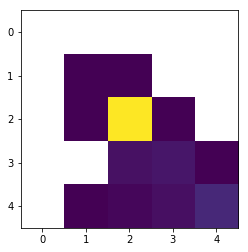

In [26]:
masked_data = data.copy()
masked_data[masked_data == 0.0] = np.nan
plt.imshow(masked_data)

Doesn't look very interesting because of our poor choice of energy bins, but you get the point!

## Fixed Source and Subcritical

OpenMC has primarily been used for eigenvalue simulations, but it does have a fixed source simulation mode. To use this mode, one simply has to change the `Settings.run_mode` attribute. Let's create a simple model with a point source and run it in fixed source mode.

In [27]:
m = openmc.Material()
m.add_element('Zr', 1.0)
m.set_density('g/cm3', 6.0)
mats = openmc.Materials([m])
mats.export_to_xml()

sphere = openmc.Sphere(R=100.0, boundary_type='vacuum')
cell = openmc.Cell(fill=m, region=-sphere)
geom = openmc.Geometry(openmc.Universe(cells=[cell]))
geom.export_to_xml()

In fixed source mode, we still have to specify a number of batches. In this case, they don't divide fission generations. Rather, each batch is a realization of our tally random variables.

In [28]:
settings = openmc.Settings()
settings.run_mode = 'fixed source'
settings.particles = 1000
settings.batches = 10
settings.source = openmc.Source(
    space=openmc.stats.Point(),
    energy=openmc.stats.Discrete([14.0], [1.0]),
)
settings.export_to_xml()

In [29]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

Now, let's add some Uranium to our material and see what happens if we try to run in fixed source mode still.

In [30]:
m.add_nuclide('U235', 1.0)
mats.export_to_xml()

In [31]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

1

Whoops! Looks like we had too much subcritical multiplication. Let's run again but with a much lower concentration of U235.

In [32]:
m.remove_nuclide('U235')
m.add_nuclide('U235', 1e-5)
mats.export_to_xml()
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0